In [9]:
import os
os.environ['PYTHONHASHSEED'] = '0'

import tensorflow as tf
import numpy as np
tf.reset_default_graph()

random_seed = 42
from numpy.random import seed
seed(random_seed)
from tensorflow import set_random_seed
set_random_seed(random_seed)
import random
random.seed(random_seed)
#print(random.getstate())

from keras import backend as K

with tf.device('/cpu:0'):
    c = tf.random_uniform([], -10, 10)
    d = tf.random_uniform([], -10, 10)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print(sess.run(c))
    print(sess.run(d))
    
    
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)   
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)    

K.set_session(sess)    
#print(sess)
#config = tf.ConfigProto(
#        device_count = {'GPU': 0}
#    )
#sess = tf.Session(config=config)
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
# https://stackoverflow.com/questions/45230448/how-to-get-reproducible-result-when-running-keras-with-tensorflow-backend
# https://stackoverflow.com/questions/46836857/results-not-reproducible-with-keras-and-tensorflow-in-python

2.7579927
3.7836285


In [10]:
import os
import sys
import warnings

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras
print(keras.__version__)

2.1.3


In [11]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'
DATA_PATH = 'data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [12]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print(len(train_ids))
print(len(test_ids))

670
65


In [13]:
current_dir = os.getcwd()
print(current_dir)

/home/chen/workspace/git_examples/kaggle-nuclei-challenge


In [14]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [39]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

filenames = []
mask_counts = []
mask_size = []
#for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    filenames.append(path + '/images/' + id_ + '.png')
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_count = 0
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_count = mask_count + 1;
        mask_size.append(sum(sum(mask_)))
    mask_counts.append(mask_count)
#        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                      preserve_range=True), axis=-1)
#        mask = np.maximum(mask, mask_)
    #Y_train[n] = mask
#X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
filenames_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    filenames_test.append(path + '/images/' + id_ + '.png')
    sizes_test.append([img.shape[0], img.shape[1]])
#    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#    X_test[n] = img
    
print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:28<00:00, 23.32it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 244.81it/s]

Done!


In [40]:
import PIL
import collections
sizes = [PIL.Image.open(f).size for f in filenames]
collections.Counter(sizes)

Counter({(256, 256): 334,
         (320, 256): 112,
         (347, 260): 5,
         (360, 360): 91,
         (640, 512): 13,
         (696, 520): 92,
         (1024, 1024): 16,
         (1272, 603): 6,
         (1388, 1040): 1})

In [42]:
sizes_test = [PIL.Image.open(f).size for f in filenames_test]
collections.Counter(sizes_test)

Counter({(161, 519): 2,
         (162, 519): 2,
         (239, 390): 1,
         (253, 519): 4,
         (256, 256): 24,
         (347, 260): 4,
         (348, 520): 4,
         (348, 524): 4,
         (640, 512): 8,
         (680, 512): 8,
         (696, 520): 4})

In [47]:
print("Number of training images: " + str(len(mask_counts)))
print("Average number of masks per training images: " + str(round(np.mean(mask_counts),2)))
print("Total number of masks in all training images: " + str(len(mask_size)))
print("Average size of masks: " + str(round(np.mean(mask_size),2)))

Number of training images: 670
Average number of masks per training images: 43.97
Total number of masks in all training images: 29461
Average size of masks: 5391.87


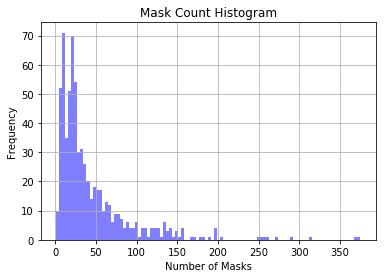

In [63]:
import matplotlib.pyplot as plt
num_bins = 100
n, bins, patches = plt.hist(mask_counts, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Number of Masks')
plt.ylabel('Frequency')
#plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.title('Mask Count Histogram')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

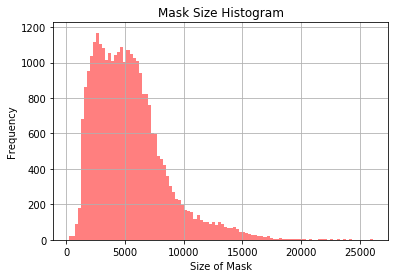

In [65]:
import matplotlib.pyplot as plt
num_bins = 100
n, bins, patches = plt.hist(mask_size, num_bins, facecolor='red', alpha=0.5)
plt.xlabel('Size of Mask')
plt.ylabel('Frequency')
#plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.title('Mask Size Histogram')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

In [64]:
print(max(mask_size))
print(min(mask_size))

26116
199
